# Imports

In [2]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go

import ipywidgets as widgets
import missingno as msno

py.offline.init_notebook_mode(connected = True)

%load_ext nb_black
#pip install rfpimp - permutation e drop column feature importance

<IPython.core.display.Javascript object>

In [3]:
sns.set_style("darkgrid")

<IPython.core.display.Javascript object>

# Data Loading

In [4]:
co2 = pd.read_csv("owid-co2-data.csv")

<IPython.core.display.Javascript object>

In [5]:
co2.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


<IPython.core.display.Javascript object>

Os dados fazem partes dos relatórios gerados e disponibilizados no site 'ourworldindata.org'. Os dados são relativos à emissão de CO2 e outros gases estufa pelos países ao longo dos anos e principais fontes responsáveis.

# Investigação estrutural

### Registros e colunas

In [6]:
co2.shape 

(25191, 60)

<IPython.core.display.Javascript object>

### Tipos de dados

In [7]:
pd.value_counts(co2.dtypes)

float64    57
object      2
int64       1
dtype: int64

<IPython.core.display.Javascript object>

## Análise de features Object

In [8]:
co2[co2.dtypes[(co2.dtypes == 'object')].index]

,iso_code,country
0,AFG,Afghanistan
1,AFG,Afghanistan
2,AFG,Afghanistan
3,AFG,Afghanistan
4,AFG,Afghanistan
...,...,...
25186,ZWE,Zimbabwe
25187,ZWE,Zimbabwe
25188,ZWE,Zimbabwe
25189,ZWE,Zimbabwe


<IPython.core.display.Javascript object>

As colunas object correspondem ao nome e abreviação do país analisado

In [9]:
co2.describe(exclude = 'number')

,iso_code,country
count,21960,25191
unique,219,243
top,OWID_WRL,EU-28
freq,271,271


<IPython.core.display.Javascript object>

## Numerical features

### Verificação de possíveis features binárias ordinais e contínuas

In [10]:
unique_val = co2.select_dtypes(include = 'number').nunique().sort_values()

<IPython.core.display.Javascript object>

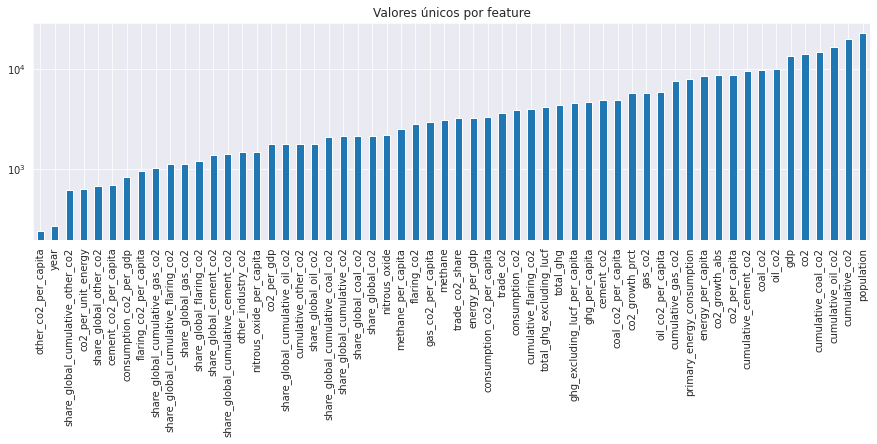

other_co2_per_capita                 243
year                                 271
share_global_cumulative_other_co2    615
co2_per_unit_energy                  625
share_global_other_co2               677
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
unique_val.plot.bar(logy = True, 
                    figsize = (15,4), 
                    title = 'Valores únicos por feature')
plt.show()
unique_val.head()

 A quantidade de valores únicos em cada feature parece indicar que todas as features presentes são contínuas

Para possível análise de variação temporal, convertemos a variável year de numérica para data

In [12]:
co2.year = co2.year.apply(lambda x: str(x)+'-01-01')

<IPython.core.display.Javascript object>

In [13]:
co2.year = pd.to_datetime(co2.year)

<IPython.core.display.Javascript object>

In [14]:
round(co2.describe(),2)

,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,flaring_co2,flaring_co2_per_capita,gas_co2,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,23949.00,23307.00,3976.00,12248.00,12218.00,17188.00,16860.00,4382.00,4381.00,8845.00,...,5651.00,5655.00,5655.00,5655.00,5655.00,2.289200e+04,1.353800e+04,8690.00,8681.00,6803.00
mean,267.86,4.17,-2.42,12.89,0.11,175.36,1.55,15.00,0.88,108.75,...,6.87,79.07,1.90,29.09,0.60,7.068041e+07,2.877088e+11,1569.08,25568.49,1.85
std,1521.68,14.91,182.44,77.26,0.15,786.11,2.55,40.47,5.48,441.06,...,7.27,545.01,3.32,198.15,0.89,3.794737e+08,2.180094e+12,9066.10,33319.96,1.58
min,0.00,0.00,-1658.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.10,0.00,0.00,0.00,0.00,1.490000e+03,5.543200e+07,0.00,0.00,0.05
25%,0.53,0.25,-0.89,0.13,0.02,0.32,0.05,0.25,0.02,0.38,...,2.10,2.00,0.69,0.51,0.22,1.287425e+06,9.828867e+09,7.00,3270.37,0.86
50%,4.86,1.25,1.95,0.56,0.07,3.98,0.44,2.07,0.07,4.20,...,4.44,8.53,1.08,3.46,0.38,4.869928e+06,3.037019e+10,61.40,13701.32,1.41
75%,42.82,4.66,9.70,2.90,0.16,35.53,2.15,12.60,0.20,30.83,...,8.98,30.02,1.62,11.20,0.59,1.757624e+07,1.268944e+11,352.88,35493.78,2.35
max,36702.50,748.64,1028.49,1626.37,2.74,15062.90,34.18,435.03,94.71,7553.39,...,53.65,8298.27,39.80,3078.27,10.06,7.794799e+09,1.136302e+14,162194.29,317582.50,13.49


<IPython.core.display.Javascript object>

# Quality Investigation

## Verificação de duplicatas

In [15]:
n_duplicates = co2.duplicated().sum()
print(f'Number of duplicates: {n_duplicates}')

Number of duplicates: 0


<IPython.core.display.Javascript object>

## Verificação de valores faltantes

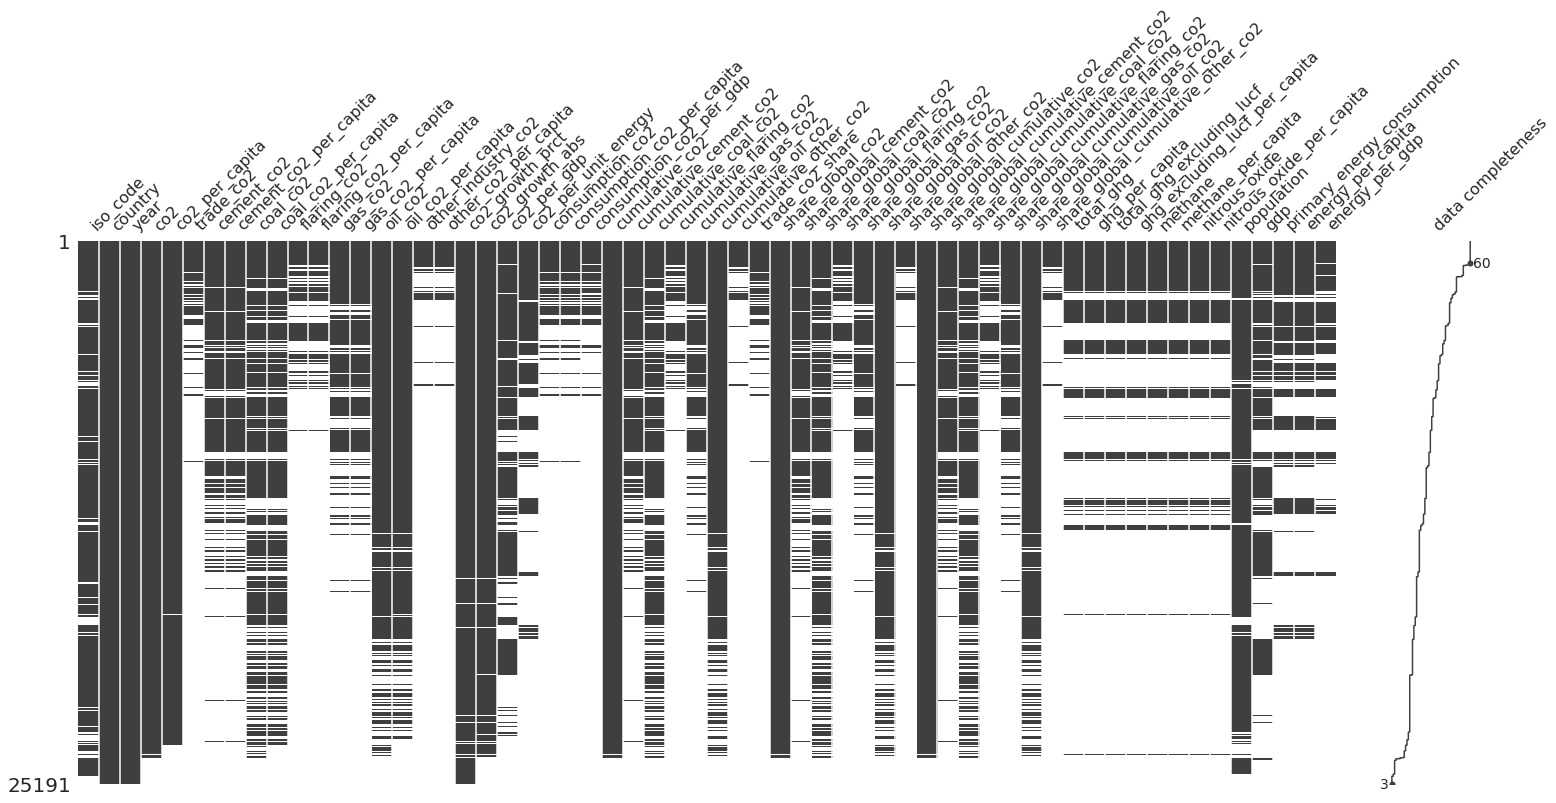

<IPython.core.display.Javascript object>

In [16]:
msno.matrix(co2, labels = True, sort = 'descending')
plt.show()

<AxesSubplot:title={'center':'Porcentagem de valores missing por feature'}>

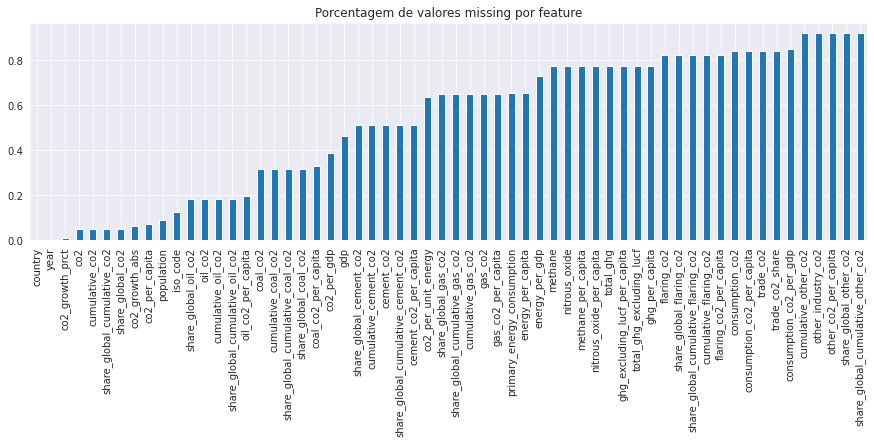

<IPython.core.display.Javascript object>

In [17]:
co2.isna().mean().sort_values().plot(kind = 'bar',figsize = (15,4), title = 'Porcentagem de valores missing por feature')

O dataset possui muitos valores missing por coluna e por registro e devem ser tratados posteriormente de acordo com as análises

## Erros nos registros

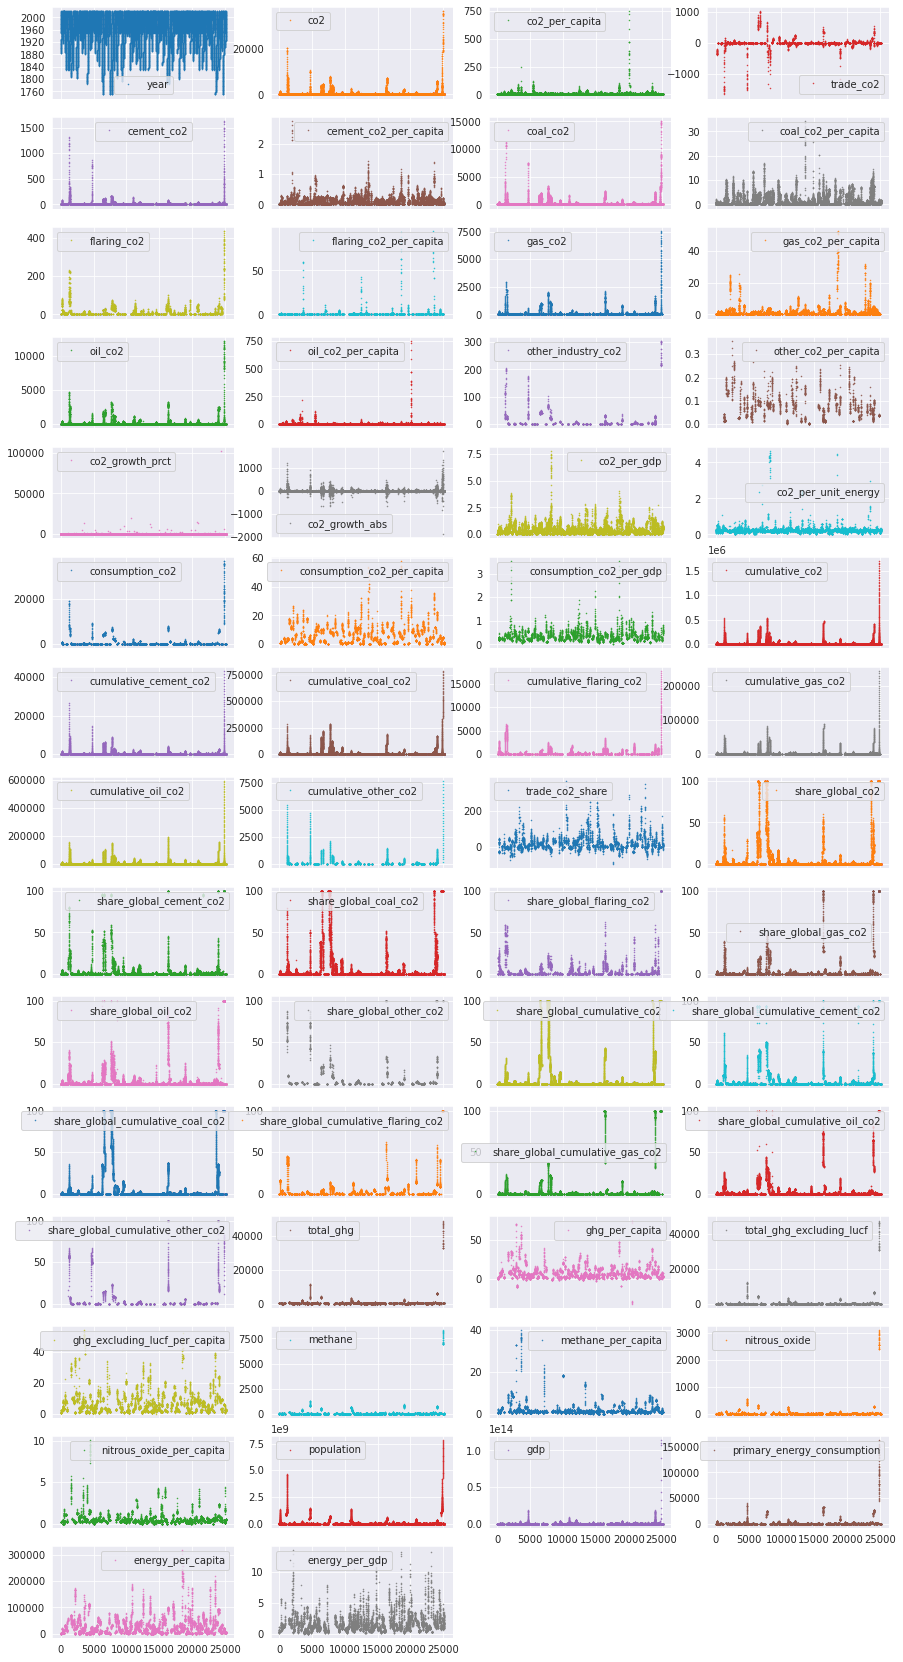

<IPython.core.display.Javascript object>

In [18]:
country = 'Brazil'
co2.plot(lw=0,
         marker = '.',
         subplots = True,
         layout = (-1, 4),
         figsize=(15,30),
         markersize = 1)
plt.show()

# Content Investigation

## Distribuição de features

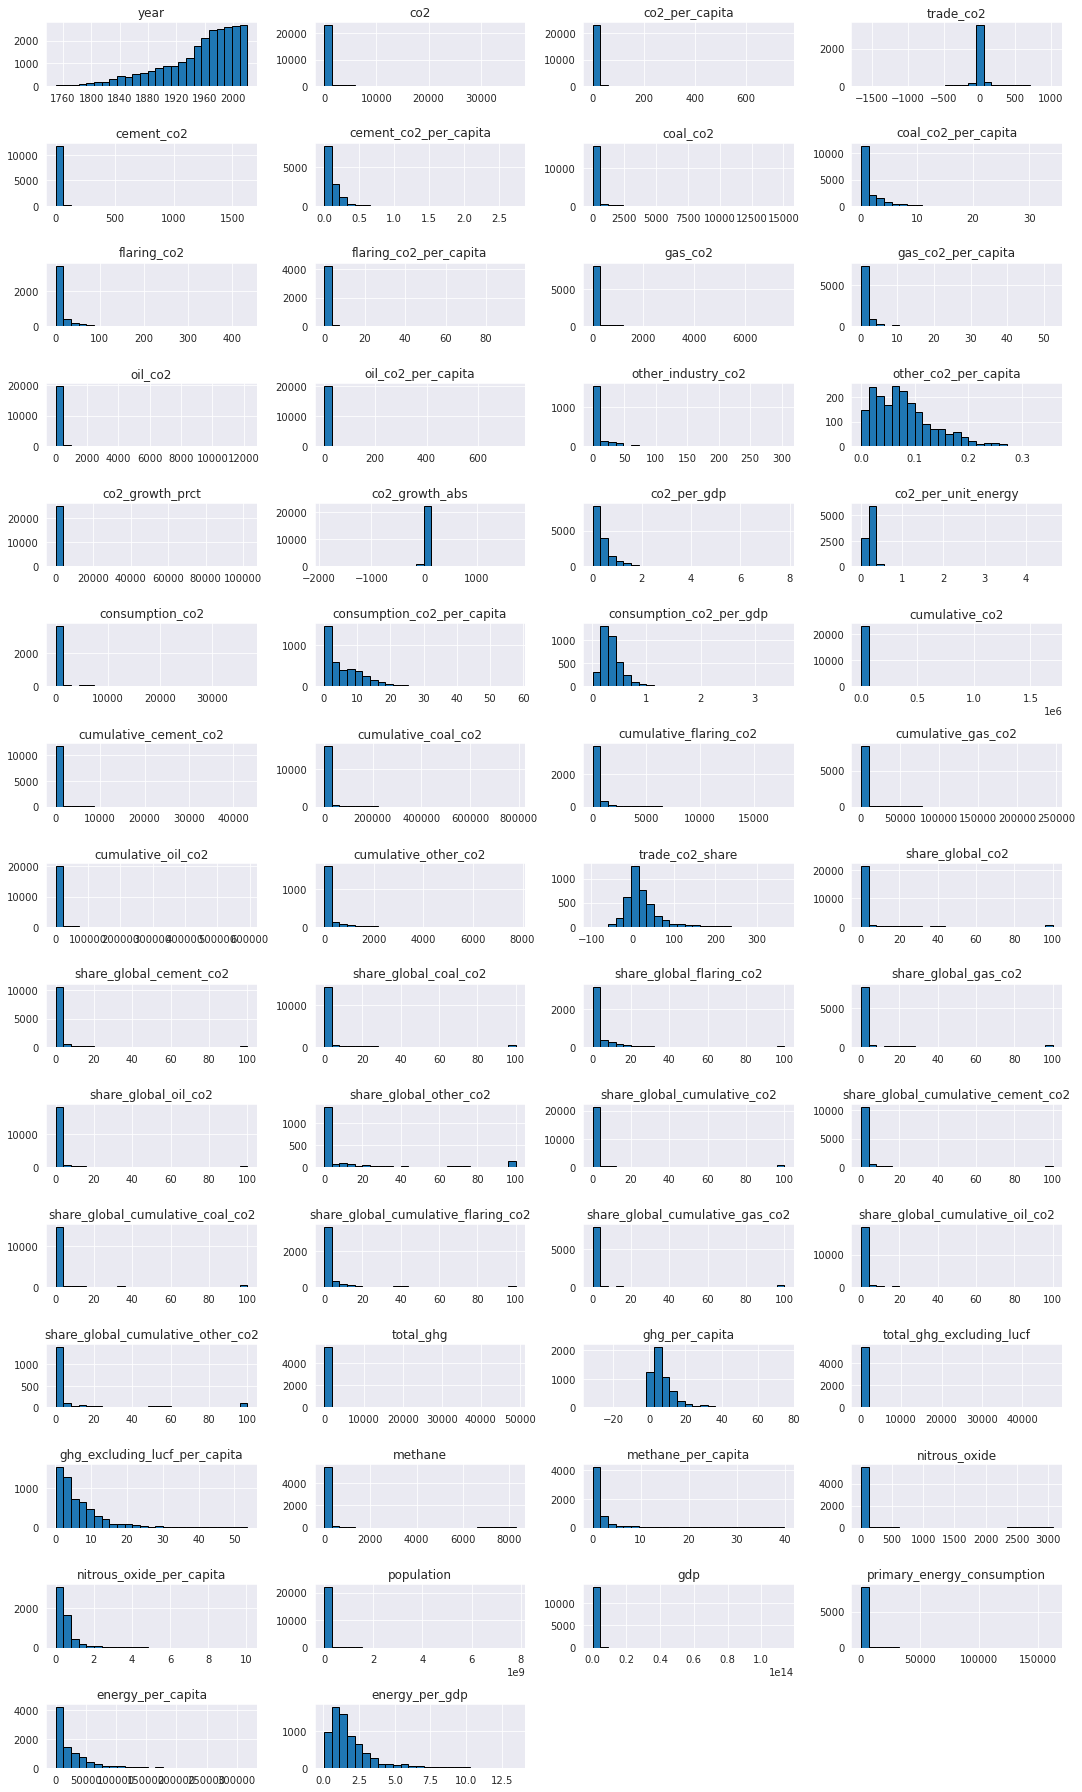

<IPython.core.display.Javascript object>

In [19]:
co2.hist(bins = 25, figsize = (15,25), layout = (-1, 4), edgecolor = 'black')
plt.tight_layout()
plt.show()

A maior parte das features parece ter distribuições enviesadas a direita ou concentradas numa faixa mais restrita de valores, sendo poucas com distribuição próxima a normalidade.

In [20]:
def normal_df_check(df):
    normals = [scipy.stats.normaltest(df[feature].dropna())[1] for feature in df.select_dtypes(include = 'number').columns.values]
    is_normal = pd.DataFrame({'Feature':df.select_dtypes(include = 'number').columns.values, 'P-value': normals})
    is_normal['is_normal'] = is_normal['P-value'].apply(lambda x: '1' if x>0.05 else '0')
    return is_normal

<IPython.core.display.Javascript object>

In [21]:
normality = normal_df_check(co2)

<IPython.core.display.Javascript object>

In [22]:
normality.sort_values(by = 'P-value', ascending = False)

,Feature,P-value,is_normal
14,other_co2_per_capita,7.503278e-60,0
36,share_global_other_co2,1.032933e-183,0
43,share_global_cumulative_other_co2,8.094356e-187,0
31,share_global_cement_co2,0.000000e+00,0
32,share_global_coal_co2,0.000000e+00,0
33,share_global_flaring_co2,0.000000e+00,0
34,share_global_gas_co2,0.000000e+00,0
35,share_global_oil_co2,0.000000e+00,0
37,share_global_cumulative_co2,0.000000e+00,0
38,share_global_cumulative_cement_co2,0.000000e+00,0


<IPython.core.display.Javascript object>

Os testes indicam que nenhuma das features tem distribuição normal.

share_global_cumulative_co2         0.295542
share_global_co2                    0.223453
share_global_cumulative_oil_co2     0.181216
share_global_cumulative_coal_co2    0.178000
share_global_coal_co2               0.143543
dtype: float64

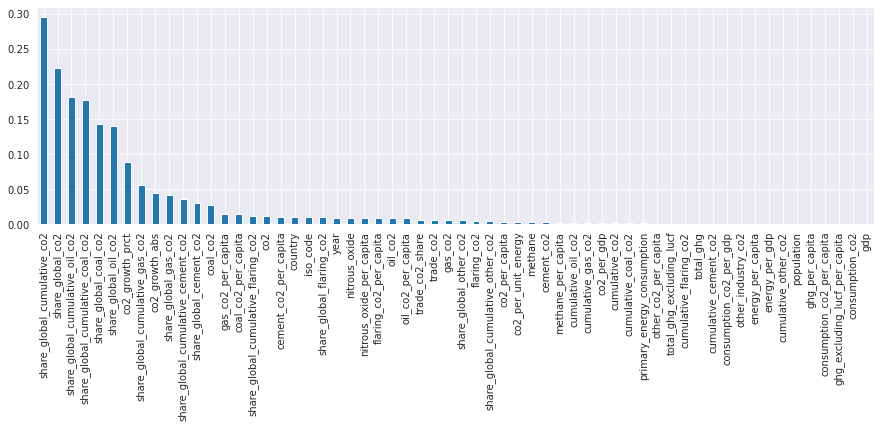

<IPython.core.display.Javascript object>

In [23]:
#Cálculo de quanto o valor da moda de cada feature representa em relação ao dataset
most_frequent_entry = co2.mode()
df_freq = co2.eq(most_frequent_entry.values[0], axis =1)
df_freq = df_freq.mean().sort_values(ascending = False)
display(df_freq.head())
df_freq.plot.bar(figsize = (15,4))
plt.show()

## Padrões nas Features

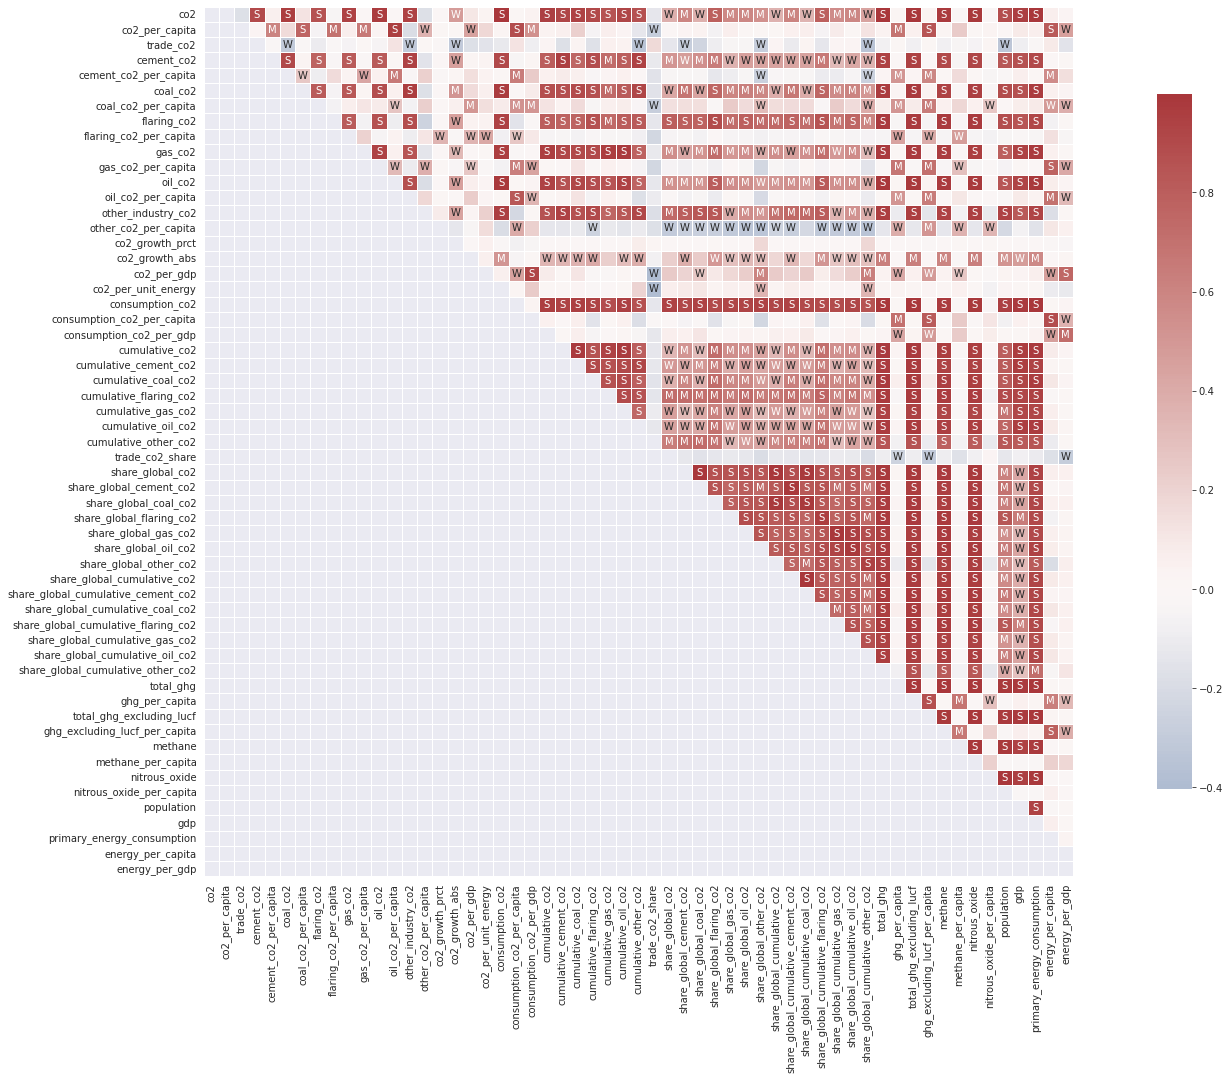

<IPython.core.display.Javascript object>

In [24]:

    co2_corr = co2.corr('pearson')

labels = np.where(np.abs(co2_corr)>0.75, "S",
         np.where(np.abs(co2_corr)>0.5, "M",
         np.where(np.abs(co2_corr)>0.25, "W", "")))

# Plot correlation matrix

plt.figure(figsize = (30,16))

#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(co2_corr.shape), k=1).astype("bool")

sns.heatmap(co2_corr, mask=lower_triangle_mask, square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});
plt.show()

In [25]:
df_corr_stacked = co2_corr.where(lower_triangle_mask).stack().sort_values()
display(df_corr_stacked[-80:-57])

total_ghg_excluding_lucf          share_global_co2               0.986978
total_ghg                         share_global_co2               0.987107
total_ghg_excluding_lucf          oil_co2                        0.987530
share_global_cumulative_co2       share_global_co2               0.988621
total_ghg                         oil_co2                        0.988761
methane                           total_ghg                      0.989602
nitrous_oxide                     total_ghg_excluding_lucf       0.989987
share_global_cumulative_gas_co2   share_global_gas_co2           0.990046
population                        nitrous_oxide                  0.991108
nitrous_oxide                     total_ghg                      0.993523
                                  methane                        0.994699
total_ghg                         consumption_co2                0.995939
primary_energy_consumption        co2                            0.996340
share_global_coal_co2             shar

<IPython.core.display.Javascript object>

### Relação das demais features com a variável CO2

<Figure size 1152x864 with 0 Axes>

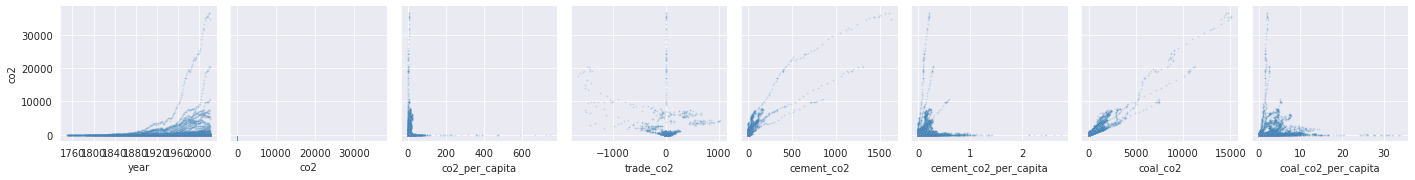

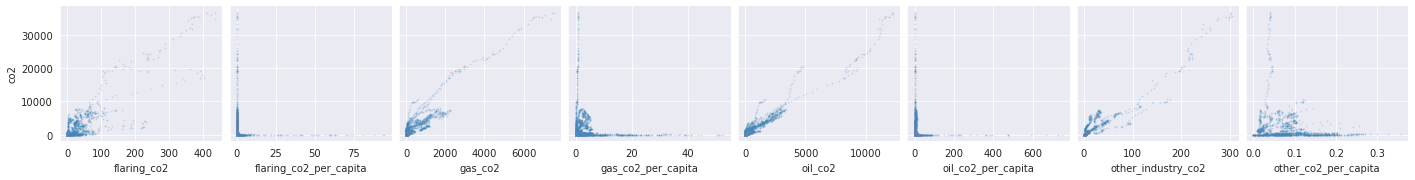

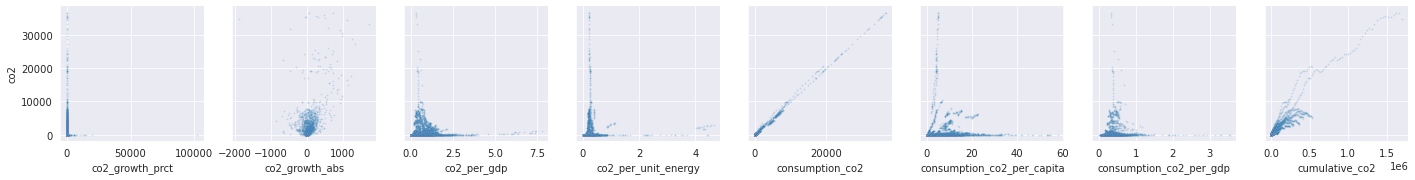

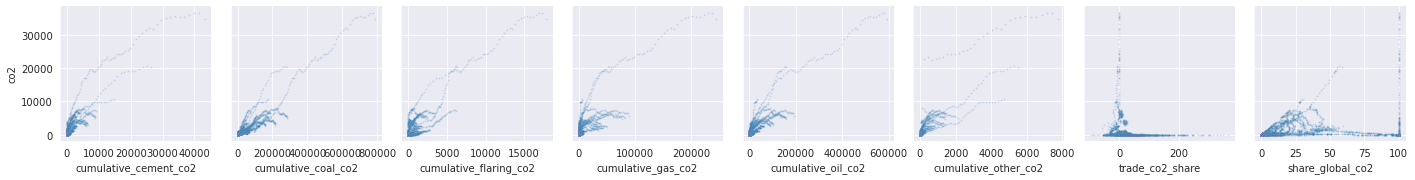

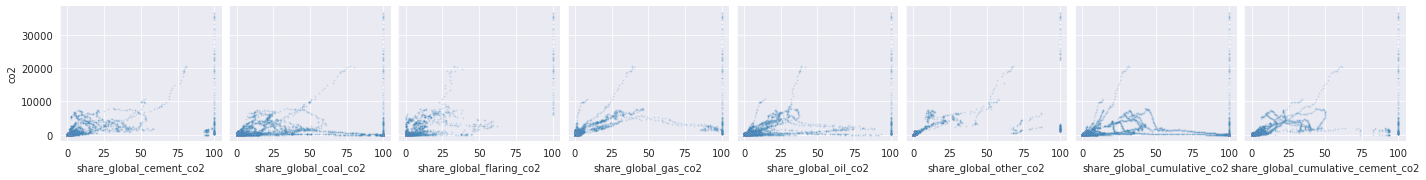

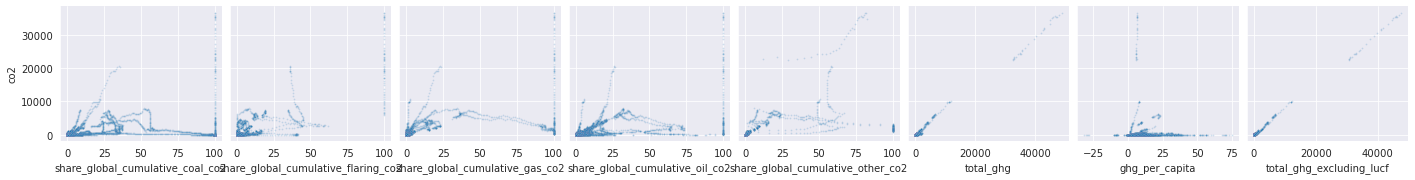

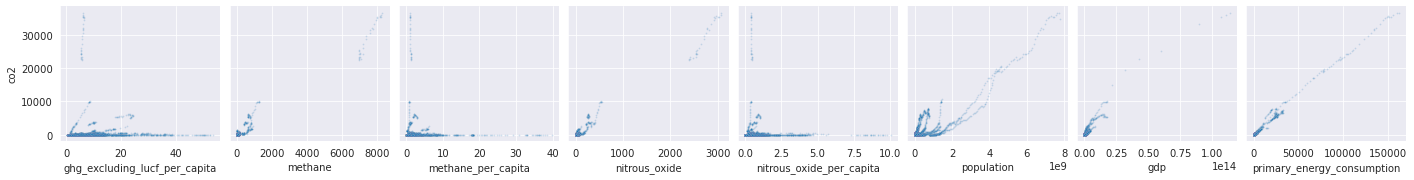

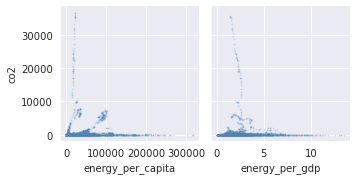

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(16,12))
for i in range(2, 60, 8):
    sns.pairplot(co2, palette = 'Spectral', y_vars = 'co2', x_vars = co2.columns[i:i+8], plot_kws={"s": 3, "alpha": 0.2})
plt.show()

Apesar dos gráficos não fazerem distinções entre países, muitos apresentam um crescimento proporcional em relação a emissão de CO2, como *primary_energy_consumption*, *consumption_co2*, *total_ghg*. 

Para detalhar mais o perfil por região, será feita uma seleção dos continentes e seus valores mais recentes.

In [27]:
dropdown1 = widgets.Dropdown(options = co2.columns.values)
dropdown2 = widgets.Dropdown(options = co2.columns.values)


ui = widgets.HBox([dropdown1, dropdown2])

def update_plot(feature1, feature2):
    plt.figure(figsize = (12,6))
    sns.scatterplot(data = co2, x=feature1, y=feature2, color = 'green')
    plt.title('Individual Pairplots', fontsize = 15)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    
    plt.show()
    
out = widgets.interactive_output(update_plot, {'feature1':dropdown1, 'feature2': dropdown2})
display(ui, out)

Output()

<IPython.core.display.Javascript object>

In [47]:
continents = ['South America', 'China', 'India', 'EU-28', 'Oceania', 'Africa', 'Europe (excl. EU-28)', 'Asia (excl. China & India)', 'United States', 'North America (excl. USA)','World']
co2_continents = co2[(co2.country.isin(continents))].sort_values(by='year')

<IPython.core.display.Javascript object>

In [48]:
dropdown1 = widgets.Dropdown(options = co2.columns[3:])
#plt.figure(figsize=(20,6))
def update_plot(variable):
    time_series = px.line(x='year', 
                          y=variable, 
                          color = 'country', 
                          data_frame = co2_continents, 
                          width = 1200, 
                          height = 600, 
                          range_x = ['1825-01-01','2020-01-01'])
    time_series.update_layout(
    
    title={
        'text': f"{(variable.capitalize())} per Region Through the Years",
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 22})
    time_series.show()
#plt.xlim([1825,2020])
#plt.title("CO2 Emissions by Continent Through the Years")
widgets.interact(update_plot, variable = dropdown1)

interactive(children=(Dropdown(description='variable', options=('co2', 'co2_per_capita', 'trade_co2', 'cement_…

<function __main__.update_plot(variable)>

<IPython.core.display.Javascript object>

* Apesar do aparente controle nas emissões em grandes países e nos continentes, o nível de emissões por ano parece ainda estar crescente.
* Pico de emissão por queima de gás natural na extração de petróleo entre as decadas de 60 e 80 na Ásia.
* Aumento exponencial na emissão por queima de carvão na China a partir dos anos 2000. (Aprox 180%)
* Os Estados Unidos aumentaram consistentemente suas emissões por queima de petroleo.

- Em 2005, a China já superava as emissões do restante do continente asiático.
- Em 1997, ocorreu o protocolo de Kyoto que visava o controle de emissão de gases estufa. Em geral, houve uma leve redução na emissão de CO2 nos continentes nos anos seguintes. A partir de 2003 a China inicia um aumento contínuo como pode ser confirmado no gráfico abaixo.

In [32]:
dropdown = widgets.Dropdown(options = co2.country.unique())

def update_plot(country):
    plt.figure(figsize = (12,6))
    sns.scatterplot(data = co2[(co2.country == country)], x='year', y='co2', color = 'green')
    plt.title(country+" CO2 Emission")
    plt.xlabel("Year")
    plt.ylabel("CO2 Emission")
    
    plt.show()
    
widgets.interact(update_plot, country = dropdown)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Africa', 'Albania', 'Algeria', …

<function __main__.update_plot(country)>

<IPython.core.display.Javascript object>

In [68]:
co2_dist = co2[['country', 'year', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'cement_co2','trade_co2','other_industry_co2', 'co2']]

<IPython.core.display.Javascript object>

In [ ]:
co2_dist['coal_pct'] = co2_dist.dropna().apply(lambda x: x.coal_co2/x.co2, axis = 1)
co2_dist['oil_pct'] = co2_dist.dropna().apply(lambda x: x.oil_co2/x.co2, axis = 1)
co2_dist['flaring_pct'] = co2_dist.dropna().apply(lambda x: x.flaring_co2/x.co2, axis = 1)
co2_dist['gas_pct'] = co2_dist.dropna().apply(lambda x: x.gas_co2/x.co2, axis = 1)
co2_dist['cement_pct'] = co2_dist.dropna().apply(lambda x: x.cement_co2/x.co2, axis = 1)
co2_dist['trade_pct'] = co2_dist.dropna().apply(lambda x: x.trade_co2/x.co2, axis = 1)
co2_dist['other_industry_pct'] = co2_dist.dropna().apply(lambda x: x.other_industry_co2/x.co2, axis = 1)

In [52]:
# Distribuição de emissão de CO2 de acordo com o tipo de emissão
co2_kind = co2_continents.melt(value_vars=['coal_co2', 'oil_co2', 'cement_co2','gas_co2', 'trade_co2'], id_vars = ['year','co2','country'], var_name = 'source',value_name='co2_quota')

<IPython.core.display.Javascript object>

In [57]:
dropdown1 = widgets.Dropdown(options = co2_kind.country.unique())
#plt.figure(figsize=(20,6))
def update_plot(variable):
    time_series = px.line(x='year', 
                          y='co2_quota', 
                          color = 'source', 
                          data_frame = co2_kind[co2_kind.country == variable], 
                          width = 1200, 
                          height = 600)
    time_series.update_layout(
    
    title={
        'text': f"{(variable.title())} main Source CO2 emissions Through the Years",
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 22})
    time_series.show()
#plt.xlim([1825,2020])
#plt.title("CO2 Emissions by Continent Through the Years")
widgets.interact(update_plot, variable = dropdown1)

interactive(children=(Dropdown(description='variable', options=('World', 'EU-28', 'North America (excl. USA)',…

<function __main__.update_plot(variable)>

<IPython.core.display.Javascript object>

* Mundialmente, a queima de carvão ainda é a fração mais representativa na emissão de CO2,arrastado principalmente pela China e Índia, apesar de grandes representantes mundiais como Estados Unidos, outros países da América do Norte e União Europeia e Ásia.
* O Leste europeu possui com principal fonte de emissão a queima de gás, seguido pela queima de óleo e carvão.

In [67]:
pcts = co2_dist.fillna(value=0)
pcts.set_index(pcts.year.year, inplace = True)

<IPython.core.display.Javascript object>

In [77]:
dropdown = widgets.Dropdown(options = co2.country.unique())

def update_plot(country):
    pcts[(pcts.country == country) & (pcts.index>='1990-01-01')].iloc[:,10:17].plot(kind='bar', stacked=True, figsize = (12,6))
    plt.title(country+' CO2 Source Distribution')
    plt.ylabel('CO2 %')
widgets.interact(update_plot, country = dropdown)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Africa', 'Albania', 'Algeria', …

<function __main__.update_plot(country)>

<IPython.core.display.Javascript object>

A maior contribuição nas emissões de CO2 concentra-se ainda nas emissões a partir da queima de petróleo seguido pela queima de carvão.